In [3]:
from DOPU_given_timerange import get_cleaned_df
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

NUMBER_OF_ZONES = 265

In [4]:
get_cleaned_df()

Processing files: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


In [5]:
df = pd.read_parquet("all_cleaned_data/all_cleaned_data.parquet")
df.head()

,VendorID,PickupDatetime,DropoffDatetime,TripDuration,PassengerCount,TripDistance,PULocationID,DOLocationID,PaymentType,FareAmount,ExtraCharges,MTATax,TipAmount,TollsAmount,ImprovementSurcharge,TotalAmount,CongestionSurcharge,AirportFee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,8.433333,1.0,0.97,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.300000,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,6.316667,1.0,1.10,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.900000,2.5,0.0
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,12.750000,1.0,2.51,48,238,1,14.9,1.0,0.5,15.00,0.0,1.0,34.900002,2.5,0.0
3,2,2023-01-01 00:10:29,2023-01-01 00:21:19,10.833333,1.0,1.43,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.680000,2.5,0.0
4,2,2023-01-01 00:50:34,2023-01-01 01:02:52,12.300000,1.0,1.84,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.799999,2.5,0.0


In [6]:
def generate_zone_duration_matrix(df, save_path='zone_duration_matrix.npy', force_recompute=False):
    if os.path.exists(save_path) and not force_recompute:
        print(f"Loading precomputed matrix from '{save_path}'...")
        return np.load(save_path)

    duration_matrix = np.full((NUMBER_OF_ZONES+1, NUMBER_OF_ZONES+1, 2), np.nan)

    grouped = df.groupby(['PULocationID', 'DOLocationID'])['TripDuration']

    for (pu, do), durations in tqdm(grouped, desc="Processing zones"):
        duration_matrix[pu, do, 0] = durations.mean()
        duration_matrix[pu, do, 1] = durations.std()

    np.save(save_path, duration_matrix)
    print(f"Matrix saved to '{save_path}'.")

    return grouped, duration_matrix

In [7]:
grouped, duration_matrix = generate_zone_duration_matrix(df, force_recompute=True)

Processing zones: 100%|██████████| 48305/48305 [00:19<00:00, 2524.55it/s] 

Matrix saved to 'zone_duration_matrix.npy'.


Percentage of filled entries: 68.53%
Most empty zones: [108 104 198 175  98 203  83 109 103 102]


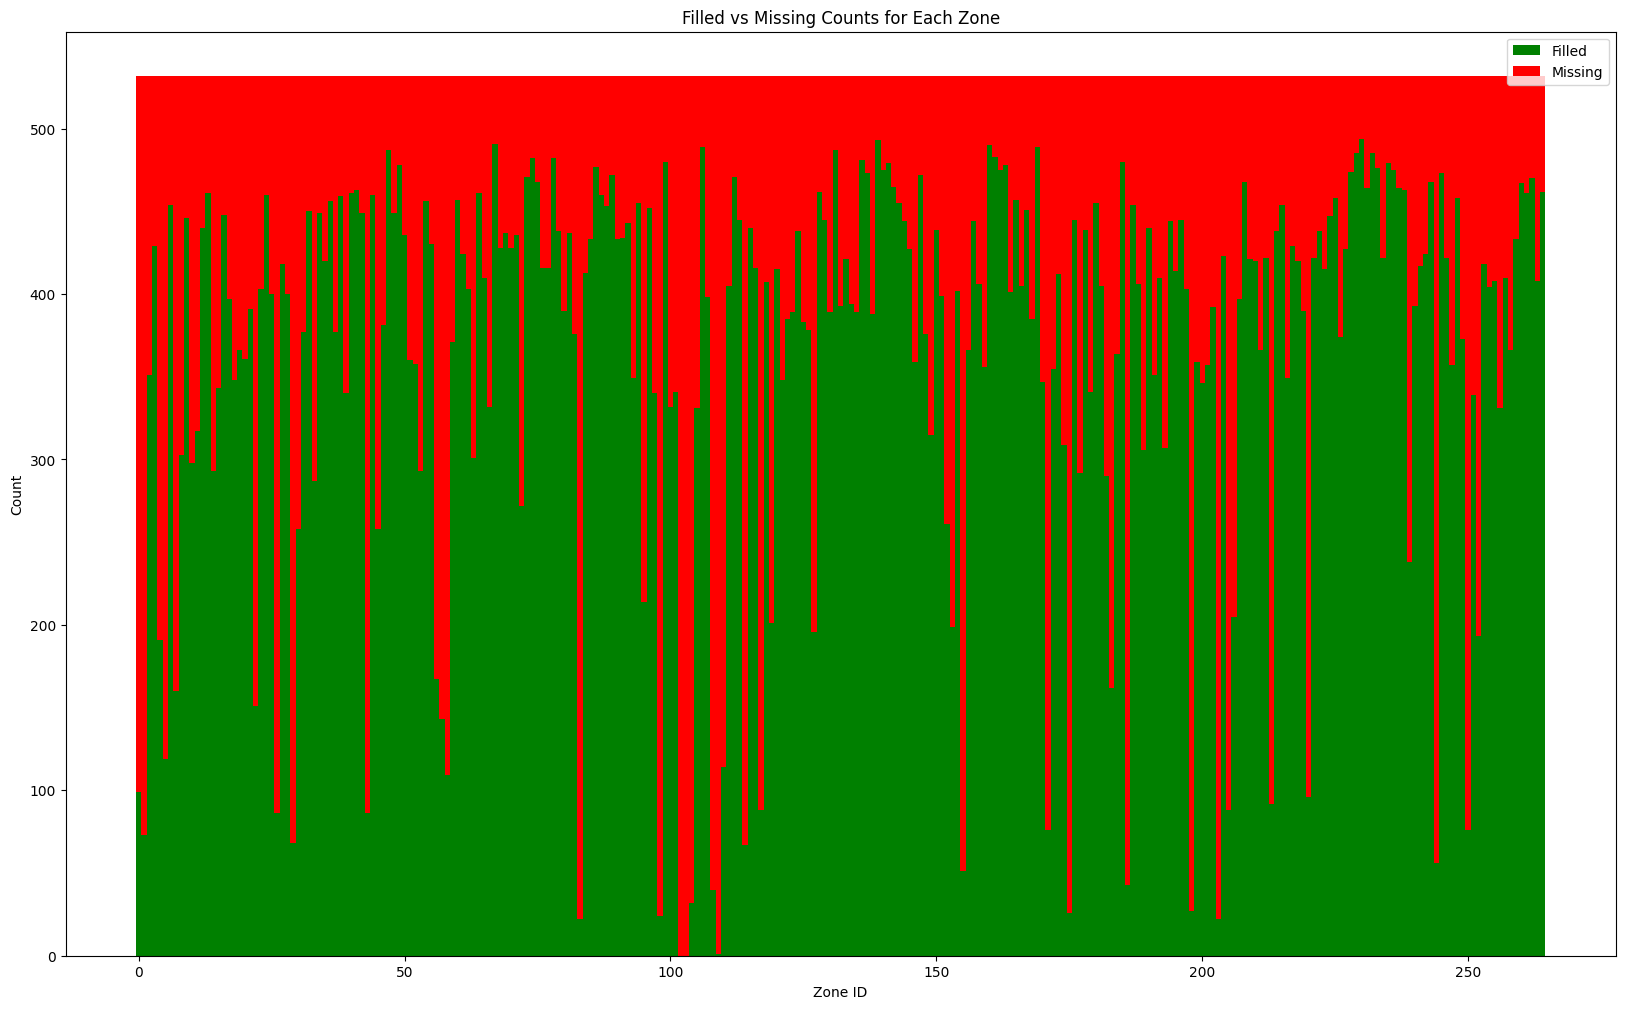

In [9]:
# Yes, technically I also should be counting the std as well, but the percentages would be the same
missing_counts = np.isnan(duration_matrix[:, :, 0]).sum(axis=1) + np.isnan(duration_matrix[:, :, 0]).sum(axis=0)
filled_counts = (~np.isnan(duration_matrix[:, :, 0])).sum(axis=1) + (~np.isnan(duration_matrix[:, :, 0])).sum(axis=0)

# Chop off the first entry since the 0th zone doesn't exist
filled_counts = filled_counts[1:]
missing_counts = missing_counts[1:]

print(f"Percentage of filled entries: {np.sum(filled_counts) / (np.sum(filled_counts) + np.sum(missing_counts)) * 100:.2f}%")

print(f"Most empty zones: {np.argsort(missing_counts)[-10:]}")

plt.figure(figsize=(20, 12))
plt.bar(range(NUMBER_OF_ZONES), filled_counts, width=1.0, label='Filled', color='green')
plt.bar(range(NUMBER_OF_ZONES), missing_counts, width=1.0, bottom=filled_counts, label='Missing', color='red')
plt.xlabel('Zone ID')
plt.ylabel('Count')
plt.title('Filled vs Missing Counts for Each Zone')
plt.legend()
plt.show()